In [1]:
import geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import ee
import os

ee.Initialize()

Map = geemap.Map(center=[31.539096,-81.422318], zoom=10)

In [2]:
#Shapefiles used for extracting pixel values - all within the GCE domain

gce_clip = 'F:/Wetlands shapefiles/GA_shapefile_wetlands/GA_simple.shp' ##Simplified GCE domain - reduced number of vertices
vcr_clip = 'F:/Wetlands shapefiles/VA_shapefile_wetlands/VA_simple.shp' ##Simplified VCR domain - reduced number of vertices
pie_clip = 'F:/Wetlands shapefiles/MA_shapefile_wetlands/MA_simple.shp' ##Simplified PIE domain - reduced number of vertices
wet_ga = geemap.shp_to_ee(gce_clip)
wet_va = geemap.shp_to_ee(vcr_clip)
wet_ma = geemap.shp_to_ee(pie_clip)
joinedFeatures = wet_ga.union()

gce_clipdiss = 'F:/Wetlands shapefiles/GA_shapefile_wetlands/GA_simpledissolve.shp'
dissolve_ga = geemap.shp_to_ee(gce_clipdiss)

gce_smalldiss = 'F:/Wetlands shapefiles/GA_shapefile_wetlands/GA_smalldissolve.shp'
gce_smalldiss2 = 'F:/Wetlands shapefiles/GA_shapefile_wetlands/GA_smalldissolve2.shp'
gce_smalldiss3 = 'F:/Wetlands shapefiles/GA_shapefile_wetlands/GA_smalldissolve3.shp'

smalldissolve_ga = geemap.shp_to_ee(gce_smalldiss)
small2dissolve_ga = geemap.shp_to_ee(gce_smalldiss2)
small3dissolve_ga = geemap.shp_to_ee(gce_smalldiss3)

gce_fluxdiss = 'F:/Wetlands shapefiles/GA_shapefile_wetlands/GA_fluxdissolve.shp'
flux_ga = geemap.shp_to_ee(gce_fluxdiss)

In [3]:
#Pixel counts of each region:
image = ee.Image('LANDSAT/LT05/C02/T1_L2/LT05_016038_19990711')
x = image.reduceRegion(geometry=flux_ga, reducer=ee.Reducer.count(), scale=30)
x.getInfo()

{'QA_PIXEL': 4193,
 'QA_RADSAT': 4193,
 'SR_ATMOS_OPACITY': 4193,
 'SR_B1': 4193,
 'SR_B2': 4193,
 'SR_B3': 4193,
 'SR_B4': 4193,
 'SR_B5': 4193,
 'SR_B7': 4193,
 'SR_CLOUD_QA': 2433,
 'ST_ATRAN': 4193,
 'ST_B6': 4193,
 'ST_CDIST': 4193,
 'ST_DRAD': 4193,
 'ST_EMIS': 4193,
 'ST_EMSD': 4193,
 'ST_QA': 4193,
 'ST_TRAD': 4193,
 'ST_URAD': 4193}

In [4]:
##FLATS
def addFLATS(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(-1.57 + 20*(RED-SWIR)/(RED+SWIR) + 68.6*(GREEN-RED)/(GREEN+RED)))', {
            'SWIR': image.select('SR_B6'),
            'RED': image.select('SR_B4'),
            'GREEN': image.select('SR_B3')
        })
    
    return image.addBands(flats.rename('flats'))

def addFLATSL5(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(-1.57 + 20*(RED-SWIR)/(RED+SWIR) + 68.6*(GREEN-RED)/(GREEN+RED)))', {
            'SWIR': image.select('SR_B5'),
            'RED': image.select('SR_B3'),
            'GREEN': image.select('SR_B2')
        })
    
    return image.addBands(flats.rename('flats'))

#NDWI
def addndwi(image):
    ndwi = ee.Image(0).expression(
        '((RED-SWIR)/(RED+SWIR))', {
            'SWIR': image.select('SR_B6'),
            'RED': image.select('SR_B4'),
            'GREEN': image.select('SR_B3')
        })
    
    return image.addBands(ndwi.rename('ndwi'))

def addndwiL5(image):
    ndwi = ee.Image(0).expression(
        '((RED-SWIR)/(RED+SWIR))', {
            'SWIR': image.select('SR_B5'),
            'RED': image.select('SR_B3'),
            'GREEN': image.select('SR_B2')
        })
    
    return image.addBands(ndwi.rename('ndwi'))

#PHENO
def addpheno(image):
    pheno = ee.Image(0).expression(
        '((GREEN-RED)/(RED+GREEN))', {
            'SWIR': image.select('SR_B6'),
            'RED': image.select('SR_B4'),
            'GREEN': image.select('SR_B3')
        })
    
    return image.addBands(pheno.rename('pheno'))

def addphenoL5(image):
    pheno = ee.Image(0).expression(
        '((GREEN-RED)/(RED+GREEN))', {
            'SWIR': image.select('SR_B5'),
            'RED': image.select('SR_B3'),
            'GREEN': image.select('SR_B2')
        })
    
    return image.addBands(pheno.rename('pheno'))

#NIRv
def addnirv(image):
    nirv = ee.Image(0).expression(
        'NIR*(NIR-RED)/(NIR+RED)', {
            'RED': image.select('SR_B4'),
            'NIR': image.select('SR_B5')
        })
    
    return image.addBands(nirv.rename('nirv'))

def addnirvL5(image):
    nirv = ee.Image(0).expression(
        'NIR*(NIR-RED)/(NIR+RED)', {
            'RED': image.select('SR_B3'),
            'NIR': image.select('SR_B4')
        })
    
    return image.addBands(nirv.rename('nirv'))

#EVI
def addeviL5(image):
    evi = ee.Image(0).expression(
        '(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)', {
            'RED': image.select('SR_B3'),
            'NIR': image.select('SR_B4'),
            'BLUE': image.select('SR_B1'),

        })
    
    return image.addBands(evi.rename('evi'))


In [5]:
##Function to cloud mask from the pixel_qa band of Landsat 5/8 SR data.
def maskL5sr(image):
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)
    # Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    # Replace the original bands with the scaled ones and apply the masks.
    return image.addBands(opticalBands, None, True) \
    .addBands(thermalBands, None, True) \
    .updateMask(qaMask) \
    .updateMask(saturationMask)

In [6]:
#Data load
# df1 = pd.read_csv('C:/Users/arj26323/Documents/Data/flats/flats_pairs.csv')
df1 = pd.read_csv('C:/Users/arj26323/Documents/Data/flats/flats_pairdates.csv')
df1['Date_A'] = pd.to_datetime(df1['Date_A'], format = '%Y-%m-%d')
df1['Date_B'] = pd.to_datetime(df1['Date_B'], format = '%Y-%m-%d')

#Tides
tides = pd.read_csv('C:/Users/arj26323/Documents/Data/flats/water_level_filtered_1999_2022.csv')
tides['Date'] = pd.to_datetime(tides['Date'], format = '%m/%d/%Y')

tides['Verified_m'] = tides['Verified_m'].str.replace("\U00002013", "-").str.replace(r'^-$', '0', regex=True).astype(float)

# display(tides['Date'])

dictide = tides.groupby(['Date'], as_index = False).aggregate({'Verified_m': np.mean}).set_index('Date').to_dict()['Verified_m'] 

# df1['Tide_height'] = df1['Date'].map(dictide)

df1['Tide_A'] = df1['Date_A'].map(dictide).astype(float)
df1['Tide_B'] = df1['Date_B'].map(dictide).astype(float)

df1 = df1[df1['Tide_A'].notna() & df1['Tide_B'].notna()]
df1['Tide_diff'] = df1['Tide_B'] - df1['Tide_A'] 

df1


,Unnamed: 0,Image_x,Sensor_x,LS_x,Date_x,Date_A,Image_y,Sensor_y,LS_y,Date_y,Date_B,Tide_A,Tide_B,Tide_diff
0,0,LANDSAT/LT05/C02/T1_L2/LT05_016038_19990711,Landsat 5/7,Landsat 5,1999-07-11,1999-07-11,LANDSAT/LE07/C02/T1_L2/LE07_017038_19990710,Landsat 7/5,Landsat 7,1999-07-10,1999-07-10,-1.453000,-1.697333,-0.244333
1,1,LANDSAT/LT05/C02/T1_L2/LT05_016038_19990727,Landsat 5/7,Landsat 5,1999-07-27,1999-07-27,LANDSAT/LE07/C02/T1_L2/LE07_017038_19990726,Landsat 7/5,Landsat 7,1999-07-26,1999-07-26,-0.645000,-0.911667,-0.266667
2,2,LANDSAT/LT05/C02/T1_L2/LT05_016038_19990812,Landsat 5/7,Landsat 5,1999-08-12,1999-08-12,LANDSAT/LE07/C02/T1_L2/LE07_017038_19990811,Landsat 7/5,Landsat 7,1999-08-11,1999-08-11,0.426667,-0.031667,-0.458333
3,3,LANDSAT/LT05/C02/T1_L2/LT05_016038_19990828,Landsat 5/7,Landsat 5,1999-08-28,1999-08-28,LANDSAT/LE07/C02/T1_L2/LE07_017038_19990827,Landsat 7/5,Landsat 7,1999-08-27,1999-08-27,0.575667,0.017000,-0.558667
4,4,LANDSAT/LT05/C02/T1_L2/LT05_016038_19990913,Landsat 5/7,Landsat 5,1999-09-13,1999-09-13,LANDSAT/LE07/C02/T1_L2/LE07_017038_19990912,Landsat 7/5,Landsat 7,1999-09-12,1999-09-12,1.164667,1.143667,-0.021000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
633,48,LANDSAT/LC08/C02/T1_L2/LC08_017038_20220903,Landsat 8/9,Landsat 8,2022-09-03,2022-09-03,LANDSAT/LC09/C02/T1_L2/LC09_016039_20220904,Landsat 9/8,Landsat 9,2022-09-04,2022-09-04,0.752667,0.243667,-0.509000
634,49,LANDSAT/LC08/C02/T1_L2/LC08_016038_20220912,Landsat 8/9,Landsat 8,2022-09-12,2022-09-12,LANDSAT/LC09/C02/T1_L2/LC09_017038_20220911,Landsat 9/8,Landsat 9,2022-09-11,2022-09-11,0.965333,0.621333,-0.344000
635,50,LANDSAT/LC08/C02/T1_L2/LC08_016039_20220912,Landsat 8/9,Landsat 8,2022-09-12,2022-09-12,LANDSAT/LC09/C02/T1_L2/LC09_017038_20220911,Landsat 9/8,Landsat 9,2022-09-11,2022-09-11,0.965333,0.621333,-0.344000
636,51,LANDSAT/LC08/C02/T1_L2/LC08_017038_20220919,Landsat 8/9,Landsat 8,2022-09-19,2022-09-19,LANDSAT/LC09/C02/T1_L2/LC09_016039_20220920,Landsat 9/8,Landsat 9,2022-09-20,2022-09-20,0.021333,-0.332667,-0.354000


In [19]:
df57 = df1.iloc[:328,:] #Note: this range changed when NaN tide rows were filtered out of df1

def addTide(img):
    tidediff = img.getNumber('tidediff')
    new_value = ee.Image(tidediff).rename('tidedifference')
    return img.addBands(new_value)

calibr = []
for i in range(len(df57)):
    x = ee.Image(addFLATSL5(addphenoL5(addndwiL5(maskL5sr(ee.Image(df57.loc[i, 'Image_x']))))))
    y = ee.Image(addFLATSL5(addphenoL5(addndwiL5(maskL5sr(ee.Image(df57.loc[i, 'Image_y']))))))
    combined_image = addTide(x.addBands(y).set({'tidediff':df57.loc[i, 'Tide_diff']}))
    try:
        region = dissolve_ga #flux_ga vs. dissolve_ga
        sample57x = geemap.ee_to_pandas(combined_image.sampleRegions(collection = region, scale = 30))
        calibr.append(sample57x) 
    except Exception:
        try:
            region = flux_ga
            sample57x = geemap.ee_to_pandas(combined_image.sampleRegions(collection = region, scale = 30))
            calibr.append(sample57x)
        except Exception:
            continue

calibr_list = pd.concat(calibr)

9722


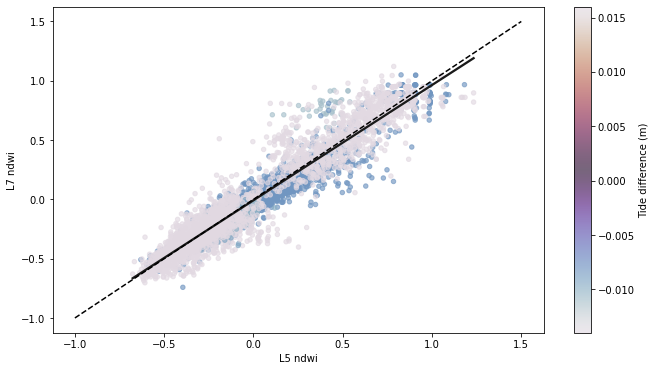

In [26]:
import seaborn as sns

calibr_list = pd.concat(calibr)

calibr_list = calibr_list[calibr_list['ndwi_1'].between(-2, 2)] #just getting rid of the outliers - pheno and ndwi
calibr_list = calibr_list[calibr_list['tidedifference'].between(-0.02, 0.02)]

# g = sns.FacetGrid(data=calibr_list, aspect=1.5, palette='BuGn', height=5) #change point size to better visualize
# g = sns.lmplot(data=calibr_list, x = 'ndwi', y='ndwi_1', aspect=1.5, palette='BuGn', height=5)
# g.map(plt.scatter, 'ndwi', 'ndwi_1').add_legend()
# g.set_axis_labels("L5 ndwi", "L7 ndwi")

fig, ax = plt.subplots()
fig.set_size_inches(11, 6)

points = plt.scatter(data = calibr_list, x = 'ndwi', y='ndwi_1',
                     c="tidedifference", s=20, cmap="twilight", alpha=0.65)
plt.colorbar(points, label = 'Tide difference (m)')
sns.regplot(x='ndwi', y="ndwi_1", data=calibr_list, scatter=False, color=".1").set(xlabel='L5 ndwi', ylabel='L7 ndwi')

plt.plot([-1, 1.5], [-1, 1.5], 'k--')

print(len(calibr_list))

In [21]:
df78 = df1.iloc[328:581,:] #Again, this range changes when NaN tide rows are filtered out

def addTide(img):
    tidediff = img.getNumber('tidediff')
    new_value = ee.Image(tidediff).rename('tidedifference')
    return img.addBands(new_value)

calibr2 = []
for i in range(332,585): #Again, this range changes when NaN tide rows are filtered out
    x = ee.Image(addFLATSL5(addphenoL5(addndwiL5(maskL5sr(ee.Image(df78.loc[i, 'Image_x']))))))
    y = ee.Image(addFLATSL5(addphenoL5(addndwiL5(maskL5sr(ee.Image(df78.loc[i, 'Image_y']))))))
    combined_image = addTide(x.addBands(y).set({'tidediff':df78.loc[i, 'Tide_diff']}))
    try:
        region = dissolve_ga
        sample78x = geemap.ee_to_pandas(combined_image.sampleRegions(collection = region, scale = 30))
        calibr2.append(sample78x) 
    except Exception:
        try:
            region = flux_ga
            sample78x = geemap.ee_to_pandas(combined_image.sampleRegions(collection = region, scale = 30))
            calibr2.append(sample78x)
        except Exception:
            continue

calibr_78 = pd.concat(calibr2)

176482


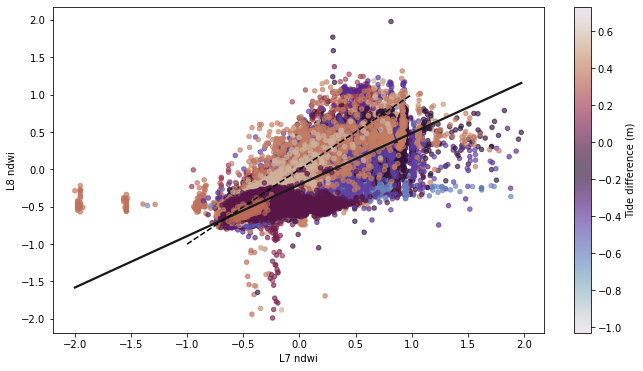

In [27]:
calibr_78 = pd.concat(calibr2)

calibr_78 = calibr_78[calibr_78['ndwi'].between(-2, 2) & calibr_78['ndwi_1'].between(-2, 2)] #just getting rid of the outliers
calibr_78 = calibr_78[calibr_78['tidedifference'].between(-0.02, 0.02)]

fig, ax = plt.subplots()
fig.set_size_inches(11, 6)

points = plt.scatter(data = calibr_78, x = 'ndwi', y='ndwi_1',
                     c="tidedifference", s=20, cmap="twilight", alpha=0.65)
plt.colorbar(points, label = 'Tide difference (m)')
sns.regplot(x='ndwi', y="ndwi_1", data=calibr_78, scatter=False, color=".1").set(xlabel='L7 ndwi', ylabel='L8 ndwi')

plt.plot([-1, 1], [-1, 1], 'k--')

# display(calibr_78)
print(len(calibr_78))

In [23]:
df89 = df1.iloc[581:,:] #Again, this range changes when NaN tide rows are filtered out

def addTide(img):
    tidediff = img.getNumber('tidediff')
    new_value = ee.Image(tidediff).rename('tidedifference')
    return img.addBands(new_value)


calibr3 = []
for i in range(585, len(df1)): #Again, this range changes when NaN tide rows are filtered out
    x = ee.Image(addFLATSL5(addphenoL5(addndwiL5(maskL5sr(ee.Image(df89.loc[i, 'Image_x']))))))
    y = ee.Image(addFLATSL5(addphenoL5(addndwiL5(maskL5sr(ee.Image(df89.loc[i, 'Image_y']))))))
    combined_image = addTide(x.addBands(y).set({'tidediff':df89.loc[i, 'Tide_diff']}))
    try:
        region = dissolve_ga
        sample89x = geemap.ee_to_pandas(combined_image.sampleRegions(collection = region, scale = 30))
        calibr3.append(sample89x) 
    except Exception:
        try:
            region = flux_ga
            sample89x = geemap.ee_to_pandas(combined_image.sampleRegions(collection = region, scale = 30))
            calibr3.append(sample89x)
        except Exception:
            continue

calibr_89 = pd.concat(calibr3)

27859


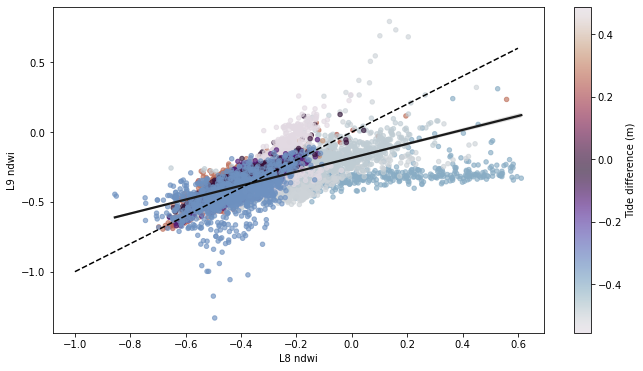

In [28]:
calibr_89 = pd.concat(calibr3)

calibr_89 = calibr_89[calibr_89['ndwi'].between(-2, 2) & calibr_89['ndwi_1'].between(-2, 2)] #just getting rid of the outliers
calibr_89 = calibr_89[calibr_89['tidedifference'].between(-0.02, 0.02)]

fig, ax = plt.subplots()
fig.set_size_inches(11, 6)

points = plt.scatter(data = calibr_89, x = 'ndwi', y='ndwi_1',
                     c="tidedifference", s=20, cmap="twilight", alpha=0.65)
plt.colorbar(points, label = 'Tide difference (m)')
sns.regplot(x='ndwi', y="ndwi_1", data=calibr_89, scatter=False, color=".1").set(xlabel='L8 ndwi', ylabel='L9 ndwi')

# g.set_axis_labels("L8 ndwi", "L9 ndwi")
plt.plot([-1, 0.6], [-1, 0.6], 'k--')

# display(calibr_89)
print(len(calibr_89))

In [14]:
df1.shape

df78 = df1.iloc[328:581,:]

df78

,Unnamed: 0,Image_x,Sensor_x,LS_x,Date_x,Date_A,Image_y,Sensor_y,LS_y,Date_y,Date_B,Tide_A,Tide_B,Tide_diff
332,4,LANDSAT/LE07/C02/T1_L2/LE07_016038_20130709,Landsat 7/8,Landsat 7,2013-07-09,2013-07-09,LANDSAT/LC08/C02/T1_L2/LC08_017038_20130708,Landsat 8/7,Landsat 8,2013-07-08,2013-07-08,0.079333,-0.194667,-0.274000
333,5,LANDSAT/LE07/C02/T1_L2/LE07_016038_20130725,Landsat 7/8,Landsat 7,2013-07-25,2013-07-25,LANDSAT/LC08/C02/T1_L2/LC08_017038_20130724,Landsat 8/7,Landsat 8,2013-07-24,2013-07-24,1.149333,0.720333,-0.429000
334,6,LANDSAT/LE07/C02/T1_L2/LE07_016038_20130810,Landsat 7/8,Landsat 7,2013-08-10,2013-08-10,LANDSAT/LC08/C02/T1_L2/LC08_017038_20130809,Landsat 8/7,Landsat 8,2013-08-09,2013-08-09,0.876333,0.626333,-0.250000
335,7,LANDSAT/LE07/C02/T1_L2/LE07_016038_20130826,Landsat 7/8,Landsat 7,2013-08-26,2013-08-26,LANDSAT/LC08/C02/T1_L2/LC08_017038_20130825,Landsat 8/7,Landsat 8,2013-08-25,2013-08-25,1.215000,1.400333,0.185333
336,8,LANDSAT/LE07/C02/T1_L2/LE07_016038_20130911,Landsat 7/8,Landsat 7,2013-09-11,2013-09-11,LANDSAT/LC08/C02/T1_L2/LC08_017038_20130910,Landsat 8/7,Landsat 8,2013-09-10,2013-09-10,1.067667,1.168333,0.100667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580,252,LANDSAT/LE07/C02/T1_L2/LE07_016038_20220507,Landsat 7/8,Landsat 7,2022-05-07,2022-05-07,LANDSAT/LC08/C02/T1_L2/LC08_016039_20220507,Landsat 8/7,Landsat 8,2022-05-07,2022-05-07,0.273667,0.273667,0.000000
581,253,LANDSAT/LE07/C02/T1_L2/LE07_016038_20220524,Landsat 7/8,Landsat 7,2022-05-24,2022-05-24,LANDSAT/LC08/C02/T1_L2/LC08_016038_20220523,Landsat 8/7,Landsat 8,2022-05-23,2022-05-23,-0.697000,-0.231333,0.465667
582,254,LANDSAT/LE07/C02/T1_L2/LE07_016038_20220726,Landsat 7/8,Landsat 7,2022-07-26,2022-07-26,LANDSAT/LC08/C02/T1_L2/LC08_016039_20220726,Landsat 8/7,Landsat 8,2022-07-26,2022-07-26,-0.904000,-0.904000,0.000000
583,255,LANDSAT/LE07/C02/T1_L2/LE07_017038_20220903,Landsat 7/8,Landsat 7,2022-09-03,2022-09-03,LANDSAT/LC08/C02/T1_L2/LC08_017038_20220903,Landsat 8/7,Landsat 8,2022-09-03,2022-09-03,0.752667,0.752667,0.000000
